# Gene Prediction with Hidden Markov Models


Hidden Markov Models (HMM) are widely used in various fields of research: speech recognition, automatic natural language processing, handwriting recognition, and bioinformatics.

The 3 main problems associated to HMMs are:

  1. Evaluation :
    - Problem: Compute the probability of observing the sequence given an HMM:
    - Solution: **Forward Algorithm**

  2. Decoding:
    - Problem: find the sequence of states that maximizes the probability of observing the sequences.
    - Solution: **Viterbi Algorithm**

  3. Training/Estimation:
    - Problem: Adjust the parameters of the HMM model to maximize the probability of generating the sequence of observations from the training data
    - Solution: **Forward-Backward Algorithm**

In this TME, we will apply the Viterbi algorithm to molecular biology data, in particular for the problem of gene prediction. 

# Some Biological background 

In this small project, we will see how statistical models can be used to extract information from raw biological data. The goal will be to specify Hidden Markov Models which will allow to annotate the positions of the genes in the genome.

The genome, the carrier of genetic information, can be thought of as a long sequence of characters written in a 4-letter alphabet: `A`, `C`, `G` and `T`. Each letter of the genome is also called a base pair (or bp). It is now relatively inexpensive to sequence a genome (some direct to consumer company have [offers](https://nebula.org/whole-genome-sequencing-dna-test/) as low as a few hundred euros for a human genome). However, we cannot understand, simply from the series of letters, how this information is used by the cell (a bit like having an instruction manual written in an unknown language, or a compiled code with no information on the machine).

An essential element is the gene, which after transcription and translation will produce proteins, the molecules responsible for much of the biochemical activity of cells.

_if you do not know about transcription and translation, a short video about the basics:_ 
https://youtube.com/shorts/mSMjwxNK2EU?feature=share

Ameoba sisters page
https://www.youtube.com/c/AmoebaSisters


## Two paragraphs summary for the impatient:

The translation into protein is done using the genetic code which, for each group of 3 letters (or bp) transcribed, matches an amino acid. These groups of 3 letters are called codons and there are $ 4 ^ 3 $, or $ 64 $. So, as a first approximation, a gene is defined by the following properties (for prokaryotic organisms):

- The first codon, called start codon is `ATG`,
- There are 61 codons which code for Amino Acids.
- The last codon, called the stop codon, marks the end of the gene and is one of the three sequences `TAA`, `TAG` or `TGA`. It does not appear in the gene.


We will integrate these different pieces of information to predict the positions of genes. Note that this figure is for the moment simplified, as we have omitted the fact that the DNA molecule consists of two complementary strands, and therefore that the genes present on the complementary strand are seen "upside down" on our sequence. 

The regions between genes are simply called *intergenic regions*.

![Image of Yaktocat](https://cdn.kastatic.org/ka-perseus-images/1ade7bbd40ca8dbc7a55ddf4067935e42c347f35.png)

**Important information to remember for the following:**  Each gene sequence starts with a start codon and ends with a stop codon 

## A few more biological information for the uninitiated

What is a chromosome?
https://www.youtube.com/watch?v=IePMXxQ-KWY

Some more information about DNA and RNA (6min)
https://youtu.be/JQByjprj_mA

And if you like to know how protein synthesis works (9min): <br>
https://youtu.be/oefAI2x2CQM
<br>
And other video on the subject (3min):
https://www.youtube.com/watch?v=gG7uCskUOrA


What is a gene (5min)? <br>
https://www.youtube.com/watch?v=5MQdXjRPHmQ&list=PLInNVsmlBUlQT_peuWctrmGMiLngK-6fb&index=7

Here is a short (6min) video explaining the basis of gene regulation. Note that the part about operon is not important. 
https://youtu.be/h_1QLdtF8d0


# Gene Modeling

## Question 1: data download


We will be working on the first million bp of the E. coli genome (strain 042). Rather than working with the letters A, C, G, and T, we'll recode them with numbers ($ A = $ 0, $ C = $ 1, $ G = $ 2, $ T = $ 3).

The annotations provided are also encoded with integer values from $ 0 $ to $ 3 $:
- 0: the position is in a non-coding region = intergenic region
- 1: the position corresponds to a codon in phase 0
- 2: the position corresponds to a codon in phase 1 
- 3: the position corresponds to a codon in phase 2

For instance for the drawing above we have the following values:
  - `32031032031312300203031` for the sequence
  - `00000123123123123000000` for the annotation

In [8]:
# Download pickle files for the genome sequences and 
# its annotation 
import numpy as np
import pickle as pkl

Genome=np.load('genome.npy') # the first Mio bp of E. coli
Annotation=np.load('annotation.npy')# gene annotation 

## Let's split the data in two, one half for training and 
## the second half for testing.

genome_train=Genome[:500000]
genome_test=Genome[500000:]

annotation_train=Annotation[:500000]
annotation_test=Annotation[500000:]


## Question 2: Parameters Estimation / Learning

As the simplest model for separating codon sequences from intergenic sequences, we will define the hidden Markov chain whose transition graph is given below.

![modele1](modele1.png)

Such a model is defined as follows: we consider that there are 4 possible hidden states (intergenic, codon phase 0, codon phase 1, codon phase 2).

You can stay in the intergenic regions, and when you start a gene, the composition of each base of the codon is different. In order to be able to use this model to classify, it will be necessary to know the parameters for the transition matrix (so here only the probas $ a $ and $ b $), and the distribution $ (b_i, i = 0,…, 3 ) $ of the nucleotides given the four states.

``` python
Pi = np.array ([1, 0, 0, 0]) ## we start in intergenic regions
A = np.array ([[1-a, a, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1],
               [b, 1-b, 0, 0]])
B = ...

```

Given the structure of an HMM:

- The initial distribution $ \ Pi $ and the transition matrix $ A $ are estimated in the same way as for a simple Markov model (see lecture 4). In other words, the observations have no influence on the hidden states when they are known.
- The distribution of each observation only depends on the current state.

Given the nature of the data we use Multinoulli for the emissions. As a convenience we will store all the distributions $ b_i $ in a matrix $ B $ (emission probability matrix) structured as follows:

- $ K $ columns (number of possible states), $ N $ rows (number of states)
- Each row corresponds to an emission law for a state (ie, each row sums to 1)

We can now simply learn the parameters $ b_i $ with the two following steps:

1. for each state $ i \in \Sigma$ store in cell  $ b_ {i,j} $ the number of times the letter j was observed with state $ i $.
2. Normalize the rows of $ B $ to sum to one.

Write the code of the function `def learnHMM (allX, allS, N, K):` which learns a model from the combined sequence of observations and sequence of states.

In [9]:
def learnHMM(allX: np.ndarray[int], allS: np.ndarray[int], N: int, K: int) \
        -> tuple[np.ndarray[float], np.ndarray[float]]:
    """ Learn an HMM given a pair of observation and states 
    np.array[int] * np.array[int] * int * int -> 
            (np.array[double,double], np.array[double,double])
    return transition matrices A and B"""
    A = np.zeros((N, N))
    B = np.zeros((N, K))

    ### Your code here
    state_counts = np.bincount(allS)
    a, b = 0.0, 0.0
    for i in range(allS.size-1):
        a += (allS[i] == 0 and allS[i+1] == 1)
        b += (allS[i] == 3 and allS[i+1] == 0)
    a /= state_counts[0]
    b /= state_counts[3]
    A[0, 0] = 1 - a
    A[0, 1] = a
    A[-1, 0] = b
    A[-1, 1] = 1 - b
    for i in range(1, N-1):
        A[i, i+1] = 1

    for x, s in zip(allX, allS):
        B[s, x] += 1
    B /= np.vstack(B.sum(1))
    return A, B

In [36]:
pi = np.array([1, 0, 0, 0])
nb_states = 4 ## (intergenic, codon 0, codon 1, codon 2)
nb_observation = 4 ## (A,C,G,T)
A, B = learnHMM(genome_train, annotation_train, nb_states, nb_observation)
print(A)
print(B)

[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]


You should find:

$A= $
```python
[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
```
$B=$       
```python
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]
```

Note that each row sums to 1

## Question 3: Decoding using Viterbi algorithm

It is not always easy to find the coding and non-coding regions of a genome. We would like to automatically annotate the genome, that is to say to find **the most probable sequence of hidden states** which made it possible to generate the observation sequence.

### Reminders on the Viterbi algorithm (1967):

- It is used to estimate the most probable sequence of states given the observations and the model.
- It can be used to approximate the probability of observing the sequence given the model.

It uses two recursion variables:

probability: $\delta_{i}(t) = \log \max_{s_1^{t-1}} P(s_{1}^{t-1}, s_t = i, y_1^t)$

backtrack: $\Psi_{j}(t) = \arg\max_{i \in \Sigma} \delta_{i}(t-1) a_{ij}$

1\. Initialization (indices starting at 0):

$$\begin{array}{ccccccccc} 
\delta_{i} (0) &=& \log \pi_{i} +\log b_{i} (x_{0}) \\ 
\Psi_{i}(0) &=& -1
\end{array}$$
Note: We initialize the first backtracking variable $\Psi_i(0)$ to $-1$ as this variable should not be used ($-1$ does not correspond to a state).
 
2\. Recursion: 

$$ \begin{array}{ccccccccc} 
\delta_{j} (t) &=&
\displaystyle \left[\max_{i} \delta_{i}(t-1) + \log a_{ij}\right] + \log b_{j}(x_{t}) \\ 
\Psi_{j}(t) &=&
\displaystyle \arg\max_{i\in [1,\ N]} \delta_{i}(t-1) + \log a_{ij} \end{array}$$

3\. Termination (with indices at {$T-1$} in python) 

$$S^{\star} = \max_{i} \delta_{i}(T-1)$$

4\. Path 
$$\begin{array}{ccccccccc} s_{T-1}^{\star} & = &\displaystyle \arg\max_{i} \delta_{i}(T-1) \\ s_{t}^{\star} & = & \displaystyle \Psi_{t+1}(s_{t+1}^{\star}) \end{array}$$

The estimate of $\log p (x_0^{T-1} \mid \lambda)$ is obtained by finding the greatest probability in the last column of $\delta$. 

Write down the algorithm of the `viterbi (x, Pi, A, B)` method:

**Note**: if you encounter problem with $0$ cells giving infinite log values, you can try to add a very low value $\epsilon$ to all the cells of the transition matrix $a_{ij}$ and for the emission probabilities $b_j$  (something like $\epsilon=10^{-10}$). Be careful to renormalize the rows of $a$ and each of the $b_j$ to sum to 1 afterward.


In [11]:
import tqdm # tqdm library for progress bars

def viterbi(allX: np.ndarray[int], pi: np.ndarray[float], A: np.ndarray[float], B: np.ndarray[float]) -> np.ndarray[int]:
    ## initialisation
    logA, logB, logpi = np.log(A), np.log(B), np.log(pi)
    T, N = len(allX), len(pi)
    psi = np.zeros((N, T)) # |A| = N
    psi[:, 0] = -1
    delta = np.zeros((N, T)) # Initializing delta
    delta[:, 0] = logpi + logB[:, allX[0]]

    for t in tqdm.tqdm(range(1, T), total=T, initial=1):
        delta[:, t] = (np.vstack(delta[:, t-1]) + logA).max(0) + logB[:, allX[t]]
        psi[:, t] = np.argmax(np.vstack(delta[:, t-1]) + logA, axis=0)

    sstar = np.tile(0, T)
    sstar[T-1] = np.argmax(delta[:, T-1])
    for t in range(T-2, -1, -1):
        sstar[t] = psi[:, t+1][int(sstar[t+1])]
    return sstar


Here is a small sequence if you want to test your Viterbi code:

In [12]:
##Small code to test viterbi result
test_seq = "CGTGATATCATCAGGGCAGACCGGTTACATCCCCCTAACAAGCTGTTTAAAGAGAAATACTATCATGACGGACAAATTGACCTCCCTTCGTCAGTACACCACCGTAGTGGCCGACACTGGGGACATCGCGGCAATGAAGCTGTATCAACCGCAGGATGCCACAACCAACCCTTCTCTCATTCTTAACGCAGCGCAGATTCCGGAATATCGTAAGTTGATTGATGATGCTGTCGCCTGGGCGAAACAGCAGAGCAACGATCGCGCGCAGCAGATCGTGGACGCGACCGACAAACTGGCAGT"
dDNA = {"A": 0 , "C": 1 , "G": 2, "T": 3}
test_seqi = np.array([dDNA[c] for c in test_seq])

results = viterbi(test_seqi, pi, A, B)
expected = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2,
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,
       2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2,
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,
       2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2,
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,
       2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2,
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2])
print(f"Deviated from expected sequence by {np.count_nonzero(expected - results)}")

C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\327040692.py:5: RuntimeWarning: divide by zero encountered in log
  logA, logB, logpi = np.log(A), np.log(B), np.log(pi)
100%|██████████| 300/300 [00:00<00:00, 18686.63it/s]

Deviated from expected sequence by 0


You should find the following state sequence after running Viterbi:

```python
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2,
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,
       2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2,
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,
       2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2,
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1,
       2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2,
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2])
```

You can now predict the states on your test sequences 

In [13]:
predicted_states = viterbi(genome_test, pi, A, B) # ~100s on awful laptop

test_annotation = annotation_test

C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\327040692.py:5: RuntimeWarning: divide by zero encountered in log
  logA, logB, logpi = np.log(A), np.log(B), np.log(pi)
100%|██████████| 500000/500000 [00:25<00:00, 19417.98it/s]


## Display

Lets simplify the annotation to two categories: 
 - **coding** ($1$) 
 - and **non coding** ($0$).

We can simply do that with a reallocation of the matrix of predictions (note that intergenic is state 0).

```python
predicted_states[predicted_states != 0]=1 
test_annotation[test_annotation != 0]=1
```
Then we will print for each genomic position if it is a coding or a non coding position using the true annotations and add the prediction on that.
```python
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(test_annotation, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(predicted_states, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()
```

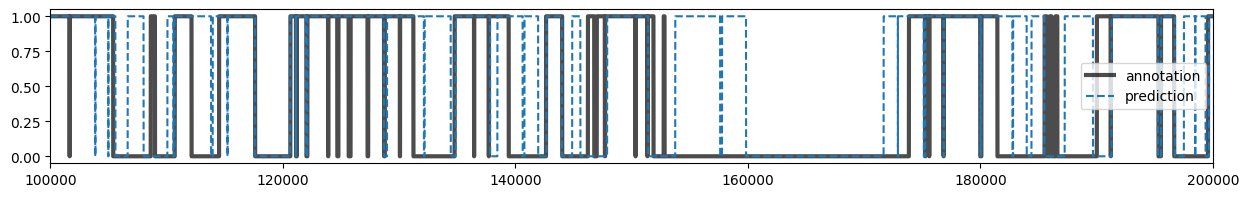

In [14]:
##Display here
predicted_states[predicted_states != 0] = 1 
test_annotation[test_annotation != 0] = 1

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(test_annotation, label="annotation", lw=3, color="black", alpha=.7)
ax.plot(predicted_states, label="prediction", ls="--")
ax.set_xlim([100000, 200000])
plt.legend(loc="best")
plt.show()

You can consider a part of the genome, plot the values between the positions 100,000 and 200,000. Comment on the quality of the prediction. 

_your comment here, which state are well predicted? Do we overpredict sometimes? Are there non coding regions predicted as coding? Why would the model predict that? Conversely, are there coding regions that are predicted as intergenic?_ 



In [15]:
# It appears we predict large coding regions quite well.
# Some thin coding regions are ignored, as there is a certain probabilistic 'cost' associated with a coding region starting
# - the probability of a 0 to 1 transition is after all roughly 0.1% and similarly for ending a prediction
# On the flip side, if a region much resembles a coding region (i.e. holds many bp that are more common in coding regions
# or bp in orders common to coding regions) it will be probabilistically advantageous to consider it a coding region

# in short, as we are ignoring the strong a-priori knowledge of start & end codons, the model will be inaccurate for regions
# improbable in nature, i.e. a coding region resembling a non-coding region and vice-versa

## Question 4 :  Performance Evaluation

Using predictions and annotations of the genome, compute the confusion matrix. 

<div  align="left"><img src="confusion.png" width="200"></div>

In other words, we have: 
- TP = True Positives, coding regions that are correctly predicted,
- FP = False Positives, intergenic regions predicted as coding regions,
- TN = True Negatives, intergenic regions correctly predicted,
- FN = False Negatives, coding regions predicted as intergenic.

**non coding** state has index $0$, the other states ($1,2,3$) are **coding** states.

![](conf2.png)

[[202819 152699]
 [ 31460 113022]]


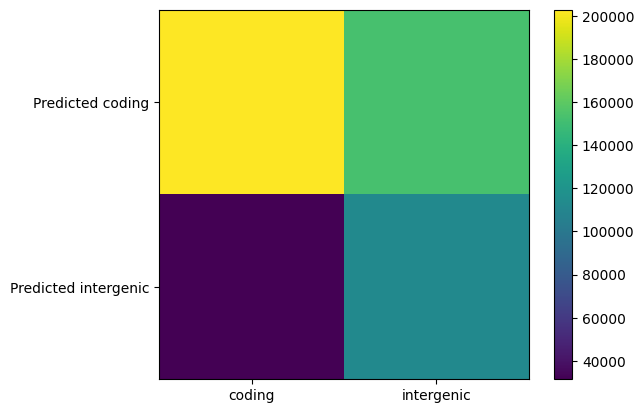

In [16]:
def create_confusion_matrix(true_sequence: np.ndarray[bool], predicted_sequence: np.ndarray[bool]) -> np.ndarray[int]:
    eq = (true_sequence == predicted_sequence)
    neq = np.logical_not(eq)
    true_pos = (eq & true_sequence).sum()
    true_neg = eq.sum() - true_pos
    return np.array([
        [true_pos,
         (neq & predicted_sequence).sum()],
        [(neq & true_sequence).sum(),
         true_neg]])

###Display the confusion matrix
import matplotlib.pyplot as plt 

mat_conf=create_confusion_matrix(test_annotation, predicted_states)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 2, 1))
ax.set_yticks(np.arange(0, 2, 1))

# Labels for major ticks
ax.set_xticklabels(['coding','intergenic']);
ax.set_yticklabels(['Predicted coding','Predicted intergenic'])

print(mat_conf)
plt.show()


Give an interpretation of the results, can we use this model to predict the position of the genes in the genome?

In [17]:
# Not necessarily, but we more or less can rule out half or so of the intergenetic regions 
# while only 'losing' a tenth or so of the coding regions...

# Use of proper analysis methods on regions predicted by this algo as opposed to the entire genome
# would therefore be somewhat more cost-effective.

# However, roughly 43% of predicted-coding regions are still intergenic (as opposed to ~53%), 
# so the model seems unsatisfactory for any use-case penalizing this manner of error 

## Question 5: Generating new sequences 

Using the model estimated $ \Theta=\{Pi,A,B\}$, specify a function ` create_seq(N,Pi,A,B) ` that, given a sequence length `N` would return:
- a sequence of hidden states
- a sequence of observations.



In [18]:
def create_seq(N: int, pi: np.ndarray[float], A: np.ndarray[float], B: np.ndarray[float]):
    '''
    Return a sequence of N hidden states using Pi and A
    and for each hidden state return an observation using B
    '''
    ## your code here
    states = np.tile(0, N)
    states[0] = np.random.choice(range(pi.size), p=pi)
    observations = np.tile(0, N)
    observations[0] = np.random.choice(range(B.shape[1]), p=B[0])
    for t in tqdm.tqdm(range(1, N), total=N, initial=1):
        states[t] = np.random.choice(range(A.shape[1]), p=A[states[t-1]])
        observations[t] = np.random.choice(range(B.shape[1]), p=B[states[t]])
    return states, observations
    
create_seq(100, pi, A, B)

100%|██████████| 100/100 [00:00<00:00, 12329.23it/s]


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([2, 0, 2, 3, 3, 1, 1, 2, 1, 0, 0, 3, 1, 1, 3, 3, 3, 2, 2, 0, 3, 0,
        3, 1, 2, 2, 2, 0, 0, 3, 0, 2, 0, 1, 2, 3, 3, 3, 1, 3, 1, 1, 3, 1,
        0, 2, 2, 0, 1, 3, 1, 1, 0, 1, 3, 2, 0, 2, 3, 3, 1, 2, 1, 0, 2, 1,
        2, 2, 3, 3, 0, 1, 3, 1, 0, 3, 1, 1, 3, 3, 0, 3, 3, 3, 3, 1, 1, 0,
        3, 3, 2, 3, 1, 0, 1, 1, 1, 2, 0, 1]))

## Question 6: Improving the model

Now let's assess if we can improve our prediction by incorporating an addtional layer of information in the model. We will take into account the gene boundaries by building a model that explicitly detects start codon and stop codon.
We now want to integrate the additional information that says that a gene "always" begins with a start codon and "always" ends with a stop codon with the transition graph below.

The model now has 12 hidden states.
![](modele2.png)

- Write the corresponding transition matrix, setting the transition probabilities between letters for stop codons to 0.5.


- Adapt the emissions matrix for all states of the model. You can reuse matrix B, calculated previously. The states corresponding to the stop codons will emit only one letter with a probability $ 1 $.
For the start codon, we know that the proportions are as follows:
    - ATG : 83%, 
    - GTG: 14%,     
    - TTG: 3%

```python
Pi2 = np.array(   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ])  ##again, we start in an intergenic region
A2 =  np.array([[1-a, a, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                [0  , 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                  ... ])
B2 = ...

```


Assess the performances of the new model by comparing it to the first model on `genome_test`. 

```
predicted_states2=viterbi(genome_test,Pi2,A2,B2)
predicted_states2[predicted_states2!=0]=1 
```

```python

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction model1", ls="--")
ax.plot(etat_predits2, label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()
```

Compute the confusion matrix with those new predictions and comment the results. Is it better than the previous one?




In [19]:
state_counts = np.bincount(annotation_train)
a, b = 0.0, 0.0
for i in range(annotation_train.size-1):
    a += (annotation_train[i] == 0 and annotation_train[i+1] == 1)
    b += (annotation_train[i] == 3 and annotation_train[i+1] == 0)
a /= state_counts[0]
b /= state_counts[3]

Pi2 = np.array(
    [1  , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  ##again, we start in an intergenic region

A2 =  np.array([
    #int ,agt , t  , g  , c0 , c1 , c2 , T  , lA , uG , lG , uA  
    [ 1-a,   a,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ], # intergene
    [   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0 ], # agt
    [   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0 ], # t
    [   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0 ], # g
    [   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0 ], # codon 0
    [   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0 ], # codon 1
    [   0,   0,   0,   0, 1-b,   0,   0,   b,   0,   0,   0,   0 ], # codon 2
    [   0,   0,   0,   0,   0,   0,   0,   0, 0.5,   0, 0.5,   0 ], # end T
    [   0,   0,   0,   0,   0,   0,   0,   0,   0, 0.5,   0, 0.5 ], # end lower A
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1 ], # end upper G
    [   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ], # end lower G
    [   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ], # end upper A
])
dDNA = {"A": 0 , "C": 1 , "G": 2, "T": 3}
B2 = np.array([
    B[0, :], # intergene
    [0.83, 0, 0.14, 0.03], # agt
    [0, 0, 0, 1], # t
    [0, 0, 1, 0], # g
    B[1, :], # codon 0
    B[2, :], # codon 1
    B[3, :], # codon 2
    [0, 0, 0, 1], # end T
    [1, 0, 0, 0], # end lower A
    [0, 0, 1, 0], # end upper G
    [0, 0, 1, 0], # end lower G
    [1, 0, 0, 0], # end upper A
])

predicted_states2 = viterbi(genome_test, Pi2, A2, B2)
predicted_states2[predicted_states2 != 0] = 1 

C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\327040692.py:5: RuntimeWarning: divide by zero encountered in log
  logA, logB, logpi = np.log(A), np.log(B), np.log(pi)
100%|██████████| 500000/500000 [00:46<00:00, 10760.05it/s]


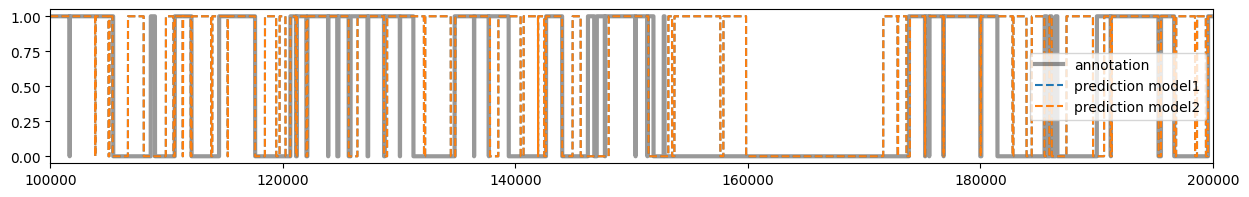

In [20]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(annotation_test, label = "annotation", lw = 3, color = "black", alpha = .4)
ax.plot(predicted_states2, label = "prediction model1", ls = "--")
ax.plot(predicted_states2, label = "prediction model2", ls = "--")
ax.set_xlim([100000, 200000])
plt.legend(loc="best")
plt.show()

[[207560 158610]
 [ 26719 107111]]


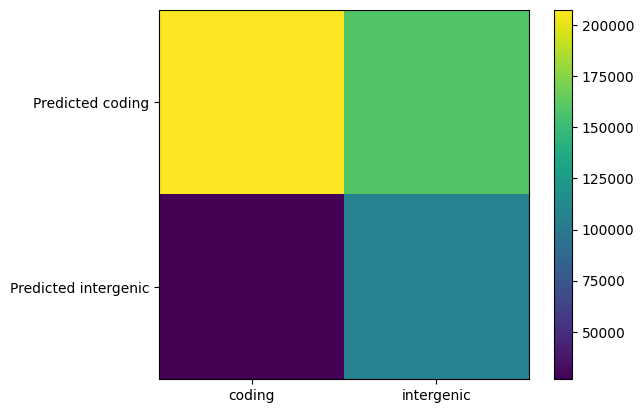

In [21]:

mat_conf=create_confusion_matrix(test_annotation, predicted_states2)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 2, 1))
ax.set_yticks(np.arange(0, 2, 1))

# Labels for major ticks
ax.set_xticklabels(['coding','intergenic']);
ax.set_yticklabels(['Predicted coding','Predicted intergenic'])

print(mat_conf)
plt.show()

In [22]:
# does not appear to be any better or worse

## Question 7: Integrating reverse strand

We now want to add the information about the genes that could come from the complementary strand. 

If you are unsure about what the forward and complementary strands means, you can check the videos above and the following video that summarizes it (the end about gene order is not important):
https://youtu.be/JC6ew2xnJBA

In summary for a sequence of DNA that is written as `GCGATGCGTTGTAAACGCGATCAGCGCAT`, we have in fact two sequences, one for each strand:
```
                 x--------->
          5'  GCGATGCGTTGTAAACGCGATCAGCGCATGGG  3'   forward (or plus) strand
              ||||||||||||||||||||||||||||||||
          3'  CGCTACGCAACATTTGCGCTAGTCGCGTACCC  5'   complementary (or minus) strand
                                  <-------x
```

On the example above, there are two genes, one on the forward strand and one on the complementary strand. Because the genes are annotated using only forward strand, we will need to detect the gene information using the _reverse complementary sequence_. 

In other words, we will add states for genes on the minus strand in the following way:
- we enter a minus gene with either `TCA`, `CTA`, `TTA` (reverse complementary of the stop codons: `TGA`, `TAG`, `TAA`)
- we leave a gene with `[C]A[TCA]` (reverse complementary of a start codon) 



The corresponding transition graph is as follow (You can see that this model has 22 states, numbered in orange):

![](model_2_strands.png)

A perfect annotation for our small example sequence woul be:
```
                 x---------->
          5'  GCGATGCGTTGATAAACGCGATCAGCGCATGGG  3'   forward (or plus) strand
              |||||||||||||||||||||||||||||||||
          3'  CGCTACGCAACTATTTGCGCTAGTCGCGTACCC  5'   complementary (or minus) strand
                                   <-------x
                            1      111111222          state number
              000123456456790000000236789012000       
                                   
```

To implement such a model, you will have to
 - deduce from the observation matrices for codons a second one for the codons that are seen on the reverse strand. You can make the hypothesis that the codon distribution is the same on both strands.
 - encode the transition matrix for observing genes on the reverse strand, starting from a reverse codon stop and ending with a codon start.


Implement a third model `Pi3, A3, B3` that would take into account the reverse strand and evaluate its performances with respect to model 1 and model 2.


**Note**: Be careful with the evaluation, the annotation given only provides the genes that are on the forward strand (the genes on the reverse strand are annotated as intergenic). If we use the numbering provided in the figure, we would do something like:

```python
predicted_states[predicted_states > 11]=0 #reverse strand genes as negatives
predicted_states[predicted_states != 0]=1 #forward strand genes as positives
```


In [23]:
state_counts = np.bincount(annotation_train)
a, b = 0.0, 0.0
for i in range(annotation_train.size-1):
    a += (annotation_train[i] == 0 and annotation_train[i+1] == 1)
    b += (annotation_train[i] == 3 and annotation_train[i+1] == 0)
a /= state_counts[0]
b /= state_counts[3]

pi3 = np.array(
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
)

A3 =  np.array([
    #  0   1   2   3   4   5   6   7   8   9  10  11   12    13   14    15  16  17  18  19  20  21  22
  [1-2*a,  a,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,0.75*a,  0,0.25*a,  0,  0,  0,  0,  0,  0,  0,  0], #  0 - we assume genes on either strand are equally likely!
    [  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  1
    [  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  2
    [  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  3
    [  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  4
    [  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  5
    [  0,  0,  0,  0,1-b,  0,  0,  b,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  6
    [  0,  0,  0,  0,  0,  0,  0,  0,0.5,0.5,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  7
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  8
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,0.5,0.5,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], #  9
    [  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], # 10
    [  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], # 11
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,0.5,     0,0.5,  0,  0,  0,  0,  0,  0,  0], # 12
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  1,  0,  0,  0,  0,  0,  0], # 13
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  1,  0,  0,  0,  0,  0,  0,  0], # 14
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  1,  0,  0,  0,  0,  0,  0], # 15
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  1,  0,  0,  0,  0,  0], # 16
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  1,  0,  0,  0,  0], # 17
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  1,  0,  0,  0], # 18
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,1-b,  0,  0,  b,  0,  0], # 19
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  1,  0], # 20
    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  1], # 21
    [  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,     0,  0,     0,  0,  0,  0,  0,  0,  0,  0,  0], # 22
])

dDNA = {"A": 0 , "C": 1 , "G": 2, "T": 3}
Binv = np.zeros_like(B)
Binv[:, 0] = B[:, 3] # reversed A = normal T
Binv[:, 3] = B[:, 0] # reversed T = normal A
Binv[:, 1] = B[:, 2] # reversed C = normal G
Binv[:, 2] = B[:, 1] # reversed G = normal C
B3 = np.array([
    #A  C  G  T
    B[0, :],                #  0
    [0.83, 0, 0.14, 0.03],  #  1
    [0, 0, 0, 1],           #  2
    [0, 0, 1, 0],           #  3
    B[1, :],                #  4
    B[2, :],                #  5
    B[3, :],                #  6
    [0, 0, 0, 1],           #  7
    [0, 0, 1, 0],           #  8
    [1, 0, 0, 0],           #  9
    [1, 0, 0, 0],           # 10
    [0, 0, 1, 0],           # 11
    [0, 0, 0, 1],           # 12
    [0, 1, 0, 0],           # 13
    [0, 1, 0, 0],           # 14
    [0, 0, 0, 1],           # 15
    [1, 0, 0, 0],           # 16
    Binv[3, :],             # 17
    Binv[2, :],             # 18
    Binv[1, :],             # 19
    [0, 1, 0, 0],           # 20
    [1, 0, 0, 0],           # 21
    [0.03, 0.14, 0, 0.83],  # 22
])


In [24]:
predicted_states3 = viterbi(genome_test, pi3, A3, B3)
print(np.histogram(predicted_states3, bins=23))

predicted_states3[predicted_states3 > 11] = 0 # reverse strand genes as negatives
predicted_states3[predicted_states3 != 0] = 1 # forward strand genes as positives

C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\327040692.py:5: RuntimeWarning: divide by zero encountered in log
  logA, logB, logpi = np.log(A), np.log(B), np.log(pi)
100%|██████████| 500000/500000 [01:31<00:00, 5453.54it/s]


(array([100058,    170,    170,    170,  73588,  73588,  73588,    170,
           83,     87,    161,      9,    152,     51,      7,    108,
          159,  59069,  59069,  59069,    158,    158,    158],
      dtype=int64), array([ 0.        ,  0.95652174,  1.91304348,  2.86956522,  3.82608696,
        4.7826087 ,  5.73913043,  6.69565217,  7.65217391,  8.60869565,
        9.56521739, 10.52173913, 11.47826087, 12.43478261, 13.39130435,
       14.34782609, 15.30434783, 16.26086957, 17.2173913 , 18.17391304,
       19.13043478, 20.08695652, 21.04347826, 22.        ]))


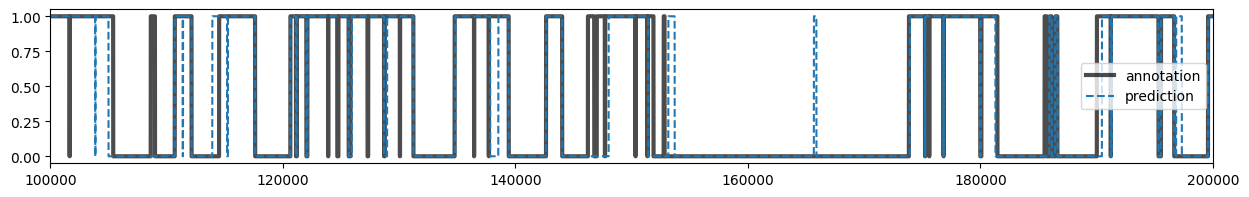

In [35]:
##Display here

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(test_annotation, label="annotation", lw=3, color="black", alpha=.7)
ax.plot(predicted_states3, label="prediction", ls="--")
ax.set_xlim([100000, 200000])
plt.legend(loc="best")
plt.show()

[[206744  15040]
 [ 27535 250681]]


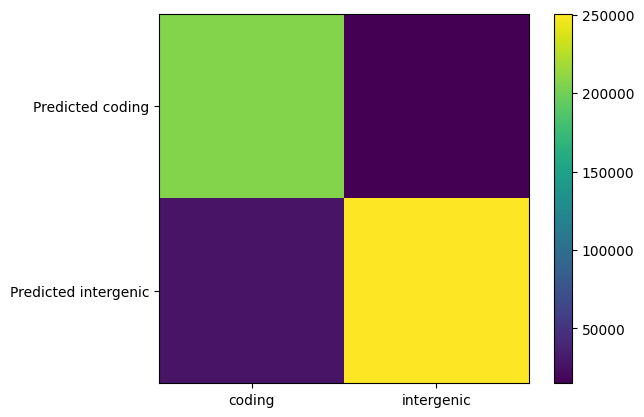

In [25]:

mat_conf=create_confusion_matrix(test_annotation, predicted_states3)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 2, 1))
ax.set_yticks(np.arange(0, 2, 1))

# Labels for major ticks
ax.set_xticklabels(['coding','intergenic']);
ax.set_yticklabels(['Predicted coding','Predicted intergenic'])

print(mat_conf)
plt.show()

In [26]:
# we had a discussion after the lecture about expected errors

def estimate_expected_error(A: np.ndarray[float], B: np.ndarray[float], pi: np.ndarray[float], N: float = 50000, it: int = 10, state_to_pred = lambda x: x):
    mat_conf = np.tile(0.0, (2,2))
    for _ in range(it):
        simul_states, simuL_observations = create_seq(N, pi, A, B)
        pred_states = viterbi(simuL_observations, pi, A, B)
        mat_conf += create_confusion_matrix(np.vectorize(state_to_pred)(simul_states), np.vectorize(state_to_pred)(pred_states))
    return mat_conf / it

100%|██████████| 500000/500000 [00:37<00:00, 13209.52it/s]
C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\327040692.py:5: RuntimeWarning: divide by zero encountered in log
  logA, logB, logpi = np.log(A), np.log(B), np.log(pi)
100%|██████████| 500000/500000 [01:22<00:00, 6086.56it/s]


[[152149.   7415.]
 [  9734. 330702.]]


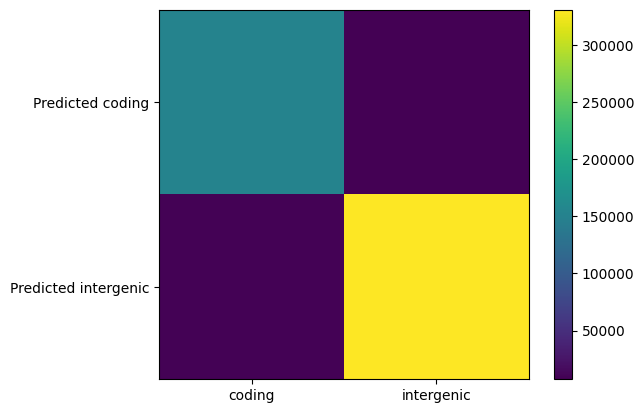

In [27]:
mat_conf = estimate_expected_error(A3, B3, pi3, 500000, 1, lambda x: 0 if (x == 0 or x > 11) else 1)

plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 2, 1))
ax.set_yticks(np.arange(0, 2, 1))

# Labels for major ticks
ax.set_xticklabels(['coding','intergenic']);
ax.set_yticklabels(['Predicted coding','Predicted intergenic'])

print(mat_conf)
plt.show()

## Question 8: Implementing the forward-backward algorithm (optional)

Using the information presented in the lecture, implement an EM estimation of the parameter based on the forward-backward algorithm. 

1.  Write a function for the forward algorithm
2.  Write a function for the backward algorithm
3.  Deduce a function to compute the smoothing probabilities
4.  Write the EM algorithm and compare the estimation results with the viterbi based method.

Did you encounted any problem while implementing this algorithm? Detail and comment each step of your analysis

**Note:** The forward and backward values decrease exponentially fast with the length of the sequence, leading to numerical issues. **You will need to integrate rescaling factors for the probabilities (as described in the lecture)**. 


In [59]:
# point 1
def forward(allX: np.ndarray[int], pi: np.ndarray[float], A: np.ndarray[float], B: np.ndarray[float], bar: bool = True) -> tuple[np.ndarray, np.ndarray]:
    T, N = len(allX), len(pi)
    f = np.tile(0.0, (N, T))
    f[:, 0] = pi * B[:, allX[0]]
    s = np.tile(0.0, T)
    s[0] = np.log(f[:, 0].sum())
    f[:, 0] /= np.exp(s[0])

    for t in (tqdm.tqdm(range(1, T), initial=1, total=T) if bar else range(1, T)):
        # for v in range(N):
        #     acc = 0
        #     for u in range(N):
        #         acc += A[u, v] * f[u, t-1]
        #     f[v, t] = B[v, allX[t]] * acc
        # same output as
        f[:, t] = B[:, allX[t]] * (np.vstack(f[:, t-1]) * A).sum(0)
        s[t] = np.log(f[:, t].sum())
        f[:, t] /= np.exp(s[t])
    return f, s

f, s = forward(np.array([2,6,6,3])-1, np.array([1,0]), np.array([[0.95, 0.05],[0.1, 0.9]]), np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]]))
print(f, "\n", s, "\n", np.exp(np.log(f[:, -1]) + s.sum()))

# i had some issues with this, but i'm fairly sure the slides are wrong
# f_F(2) ought to be 0.026389 not 0.26389
# and e_v[x_t] ought not to be calculated twice or based on previous values
# i.e. 1/6 * (0.026389 * 0.95 + 0.004167 * 0.9)
# rather than 1/6 * (0.026389 * 0.95 + 0.004167 * 0.9)

100%|██████████| 4/4 [00:00<00:00, 3000.22it/s]

[[1.         0.86363636 0.62627986 0.74136689]
 [0.         0.13636364 0.37372014 0.25863311]] 
 [-1.79175947 -1.69644929 -1.50521441 -1.95083123] 
 [0.0007148  0.00024936]


In [61]:
# point 2
def backward(allX: np.ndarray[int], pi: np.ndarray[float], A: np.ndarray[float], B: np.ndarray[float], bar: bool = True) -> tuple[np.ndarray, np.ndarray]:
    T, N = len(allX), len(pi)
    b = np.tile(0.0, (N, T))
    b[:, -1] = 1
    s = np.tile(0.0, T)
    s[-1] = np.log(b[:, -1].sum())
    b[:, -1] /= np.exp(s[-1])

    for t in (tqdm.tqdm(range(T-2, -1, -1), initial=1, total=T) if bar else range(T-2, -1, -1)):
        # for u in range(N):
        #     for v in range(N):
        #         b[u, t] += A[u, v] * B[v, allX[t+1]] * b[v, t+1]
        # same output as
        b[:, t] = (A * B[:, allX[t+1]] * b[:, t+1]).sum(1)
        s[t] = np.log(b[:, t].sum())
        b[:, t] /= np.exp(s[t])
    return b, s

b, s = backward(np.array([2,6,6,3])-1, np.array([1,0]), np.array([[0.95, 0.05],[0.1, 0.9]]), np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]]))
print(b, "\n", s)

# not entirely sure about the initialisation... wikipedia says init is 1, so i just went with that
# ought to be fine for learning? not sure about actual probas though

100%|██████████| 4/4 [00:00<00:00, 3001.65it/s]

[[0.19889534 0.35997196 0.60493827 0.5       ]
 [0.80110466 0.64002804 0.39506173 0.5       ]] 
 [-1.00237051 -1.22581455 -2.0024805   0.69314718]


In [63]:
# point 3
def forward_backward(allX: np.ndarray[int], pi: np.ndarray[float], A: np.ndarray[float], B: np.ndarray[float], bar: bool = True) -> tuple[np.ndarray, np.ndarray]:
    f, sf = forward(allX, pi, A, B, bar=bar)
    b, sb = backward(allX, pi, A, B, bar=bar)
    T = len(allX)
    for t in (tqdm.tqdm(range(1, T), initial=1, total=T) if bar else range(1, T)): # cumulative normalization values
        sf[t] += sf[t-1]
        sb[T-t-1] += sb[T-t]
    fb = np.log(f) + np.log(b) + sb + sf
    return fb

fb = forward_backward(np.array([2,6,6,3])-1, np.array([1,0]), np.array([[0.95, 0.05],[0.1, 0.9]]), np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]]), bar = False)

efb = np.exp(fb)
efb /= efb[:, 0].sum()
print(fb, "\n", efb, "\n", efb.sum(0))

# we need cumulative normalization values to calculate actual values - we can do this efficiently, though
# fb as joint proba is not normalized to sum to 1 - is missing some constant, i imagine it's P(x_[1:T])
# easy to fix if we leave log space (see above), not but relevant for EM

[[-6.94425439 -7.19168924 -7.27334328 -7.24351404]
 [       -inf -8.46203008 -8.2157178  -8.29659918]] 
 [[1.         0.78080109 0.71957905 0.74136689]
 [0.         0.21919891 0.28042095 0.25863311]] 
 [1. 1. 1. 1.]


C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\2438535460.py:9: RuntimeWarning: divide by zero encountered in log
  fb = np.log(f) + np.log(b) + sb + sf


In [55]:
def EM(allX: np.ndarray[int], pi: np.ndarray[float], A: np.ndarray[float], B: np.ndarray[float], threshold: float = 1e-5, max_iters: int = 1000, subbars: bool = False):
    T, N = len(allX), len(pi)
    f, s = forward(allX, pi, A, B, bar=subbars)
    loglike = np.log(f[:, -1]).sum() + s.sum()
    Qu = np.tile(0.0, (N, T))
    for _ in tqdm.tqdm(range(max_iters), initial = 0, total = max_iters):
        Qu = forward_backward(allX, pi, A, B, bar=subbars)
        Quv = np.tile(0.0, (N, N, T))
        Quv[:, :, 0] = np.log(pi)
        # for t in tqdm.tqdm(range(1, T), initial=1, total=T):
            # for u in range(N):
            #     for v in range(N):
            #         Quv[u, v, t] = Qu[u, t-1] + np.log(A[u, v])
            # same output as
        for t in range(1, T):
            Quv[:, :, t] = (np.log(A[:, :]) + np.vstack(Qu[:, t-1]))
        renorm = np.where(np.isfinite(Qu), Qu, 0).mean()
        Qu -= renorm
        Quv -= renorm
        Au = (np.exp(Quv[:, :, 2:]).sum(2) / np.exp(Qu[:, :]).sum(1)).T
        Au = Au / np.vstack(Au.sum(1))
        Bu = np.zeros_like(B)
        for u in range(N):
            for a in range(B.shape[1]):
                Bu[u, a] = (np.exp(Qu[u, :]) * np.where(allX==a, 1, 0)).sum() / (np.exp(Qu[u, :])).sum()
        fu, su = forward(allX, pi, Au, Bu, bar=subbars)
        loglikeu = np.log(fu[:, -1]).sum() + su.sum()
        if (loglike - loglikeu) / loglikeu < threshold:
            break
        A, B = Au, Bu
    return A, B, Qu.argmax(0)

In [ ]:
A4, B4, pi4 = np.array([[0.95, 0.05],[0.1, 0.9]]), np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]]), np.array([1,0])
s, o = create_seq(1000, pi4, A4, B4)
A5, B5, pred = EM(o, pi4, A4, B4, max_iters=100)
print(A4, "\n", B4, "\n")
print(A5, "\n", B5, "\n")

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\2438535460.py:9: RuntimeWarning: divide by zero encountered in log
  fb = np.log(f) + np.log(b) + sb + sf
100%|██████████| 100/100 [00:12<00:00,  7.98it/s]

[[0.95 0.05]
 [0.1  0.9 ]] 
 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]] 

[[0.49899687 0.50100313]
 [0.49899687 0.50100313]] 
 [[0.14493779 0.17232761 0.16776264 0.17803383 0.21985458 0.11708354]
 [0.1090931  0.12970912 0.12627312 0.13400413 0.06028297 0.44063756]] 



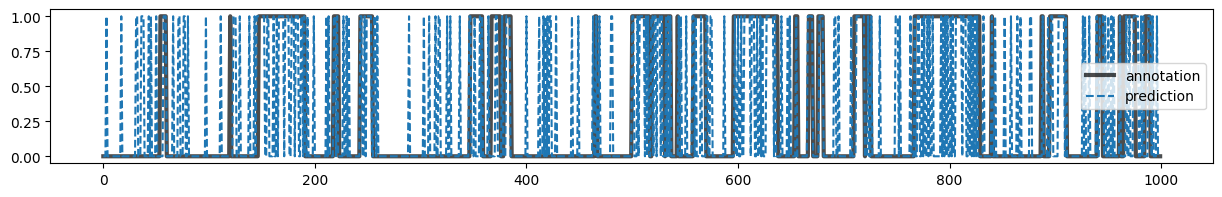

In [71]:
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(s, label="annotation", lw=3, color="black", alpha=.7)
ax.plot(pred, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()

C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\327040692.py:5: RuntimeWarning: divide by zero encountered in log
  logA, logB, logpi = np.log(A), np.log(B), np.log(pi)
100%|██████████| 1000/1000 [00:00<00:00, 19981.26it/s]


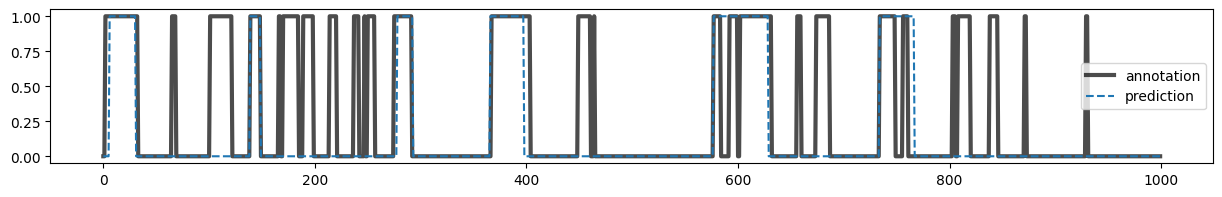

In [66]:
pred_viterbi = viterbi(o, pi4, A4, B4)

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(s, label="annotation", lw=3, color="black", alpha=.7)
ax.plot(pred_viterbi, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()

In [72]:
predA, predB, pred_em = EM(genome_test, pi3, A3, B3, max_iters = 1, subbars = True)
print(np.histogram(pred_em, bins=23))

100%|██████████| 500000/500000 [00:55<00:00, 8960.61it/s] 
C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\4277549499.py:4: RuntimeWarning: divide by zero encountered in log
  loglike = np.log(f[:, -1]).sum() + s.sum()
100%|██████████| 500000/500000 [00:00<00:00, 709151.85it/s]
C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\2438535460.py:9: RuntimeWarning: divide by zero encountered in log
  fb = np.log(f) + np.log(b) + sb + sf
C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\4277549499.py:16: RuntimeWarning: divide by zero encountered in log
  Quv[:, :, t] = (np.log(A[:, :]) + np.vstack(Qu[:, t-1]))
C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\4277549499.py:20: RuntimeWarning: invalid value encountered in divide
  Au = (np.exp(Quv[:, :, 2:]).sum(2) / np.exp(Qu[:, :]).sum(1)).T
C:\Users\Fritz\AppData\Local\Temp\ipykernel_35400\4277549499.py:25: RuntimeWarning: invalid value encountered in scalar divide
  Bu[u, a] = (np.exp(Qu[u, :]) * np.where(allX==a, 1, 0)).sum() / (np.exp

(array([100001,    129,    129,    129,  74084,  74082,  74079,    161,
           79,     82,    151,     10,    141,     50,      7,     98,
          148,  58692,  58695,  58696,    119,    119,    119],
      dtype=int64), array([ 0.        ,  0.95652174,  1.91304348,  2.86956522,  3.82608696,
        4.7826087 ,  5.73913043,  6.69565217,  7.65217391,  8.60869565,
        9.56521739, 10.52173913, 11.47826087, 12.43478261, 13.39130435,
       14.34782609, 15.30434783, 16.26086957, 17.2173913 , 18.17391304,
       19.13043478, 20.08695652, 21.04347826, 22.        ]))


In [42]:
pred_4 = viterbi(genome_test, pi3, A3, B3)
print(np.histogram(pred_4, bins=23))

(array([100058,    170,    170,    170,  73588,  73588,  73588,    170,
           83,     87,    161,      9,    152,     51,      7,    108,
          159,  59069,  59069,  59069,    158,    158,    158],
      dtype=int64), array([ 0.        ,  0.95652174,  1.91304348,  2.86956522,  3.82608696,
        4.7826087 ,  5.73913043,  6.69565217,  7.65217391,  8.60869565,
        9.56521739, 10.52173913, 11.47826087, 12.43478261, 13.39130435,
       14.34782609, 15.30434783, 16.26086957, 17.2173913 , 18.17391304,
       19.13043478, 20.08695652, 21.04347826, 22.        ]))


In [73]:
pred_4[pred_4 > 11] = 0 # reverse strand genes as negatives
pred_4[pred_4 != 0] = 1 # forward strand genes as positives
pred_em[pred_em > 11] = 0 # reverse strand genes as negatives
pred_em[pred_em != 0] = 1 # forward strand genes as positives

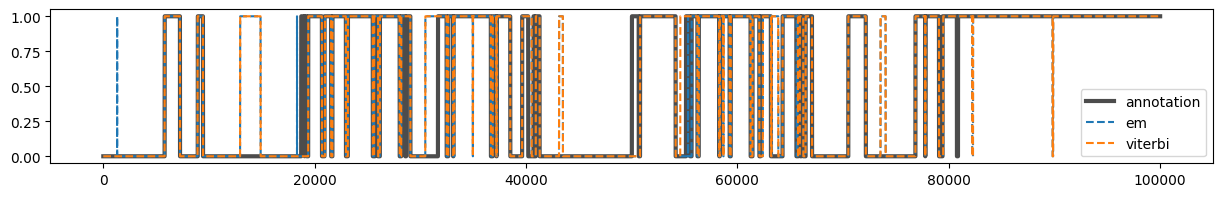

In [78]:
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(test_annotation[:100000], label="annotation", lw=3, color="black", alpha=.7)
ax.plot(pred_em[:100000], label="em", ls="--")
ax.plot(pred_4[:100000], label="viterbi", ls="--")
plt.legend(loc="best")
plt.show()